**рекуррентная нейронная сеть LSTM**

Евгений Борисов <esborisov@sevsu.ru>

---

In [33]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
# pd.options.display.max_colwidth=200 

----

In [1]:
with open('../data/text/dostoevsky-besy.txt','rt',encoding='utf-8') as f: text = f.read()    
print(len(text))    
text

921


'Праздник состоялся, несмотря ни на какие недоумения прошедшего "Шпигулинского" дня. Я думаю, что если бы даже Лембке умер в ту самую ночь, то праздник все-таки бы состоялся на утро, - до того много соединяла с ним какого-то особенного значения Юлия Михайловна. Увы, она до последней минуты находилась в ослеплении и не понимала настроения общества. Никто под конец не верил, что торжественный день пройдет без какого-нибудь колоссального приключения, без "развязки", как выражались иные, заранее потирая руки. Многие, правда, старались принять самый нахмуренный и политический вид; но вообще говоря, непомерно веселит русского человека всякая общественная скандальная суматоха. Правда, было у нас нечто и весьма посерьезнее одной лишь жажды скандала: было всеобщее раздражение, что-то неутолимо злобное; казалось, всем все надоело ужасно. Воцарился какой-то всеобщий сбивчивый цинизм, цинизм через силу, как бы с натуги.\n'

In [3]:
text = text.lower()[:-1]
abc = { c:i for i,c in enumerate(sorted(set(text))) } 

In [4]:
text

'праздник состоялся, несмотря ни на какие недоумения прошедшего "шпигулинского" дня. я думаю, что если бы даже лембке умер в ту самую ночь, то праздник все-таки бы состоялся на утро, - до того много соединяла с ним какого-то особенного значения юлия михайловна. увы, она до последней минуты находилась в ослеплении и не понимала настроения общества. никто под конец не верил, что торжественный день пройдет без какого-нибудь колоссального приключения, без "развязки", как выражались иные, заранее потирая руки. многие, правда, старались принять самый нахмуренный и политический вид; но вообще говоря, непомерно веселит русского человека всякая общественная скандальная суматоха. правда, было у нас нечто и весьма посерьезнее одной лишь жажды скандала: было всеобщее раздражение, что-то неутолимо злобное; казалось, всем все надоело ужасно. воцарился какой-то всеобщий сбивчивый цинизм, цинизм через силу, как бы с натуги.'

In [5]:
# w=15

# symbol_seq = [ [ text[i:i+w],text[i+w] ] for i in range(len(text)-w) ]
# symbol_seq

In [6]:
# eye = np.eye(max(abc.values())+1)


In [7]:
# import re
# re.split(r'[.,]',text)
# text.split('.')

In [8]:
text_encoded = np.array(list( map( lambda c: abc[c],list(text) ) ))
text_encoded = np.eye(max(abc.values())+1)[text_encoded]

In [9]:
w = 15
text_encoded_seq = [ 
    [ text_encoded[i:i+w],text_encoded[i+w] ] 
    for i in range(len(text_encoded)-w) 
]

In [10]:
X_train = np.stack([ s[0] for s in text_encoded_seq ])
y_train = np.stack([ s[1] for s in text_encoded_seq ])

X_train.shape, y_train.shape

((905, 15, 36), (905, 36))

In [11]:
import torch
import torch.nn as nn

In [12]:
class Model(nn.Module):
    
    def __init__(self, input_dim, hid_dim):
        super().__init__()
        #self.rcl0 = nn.GRU(input_dim, hid_dim,)
        self.rcl0 = nn.LSTM(input_dim, hid_dim,)
        self.dense0 = nn.Linear(hid_dim,input_dim) 
        self.softmax0 = nn.Softmax(dim=1)

    def forward(self,x):
        # o, s = self.rcl0(x)
        o, _ = self.rcl0(x)
        o = self.dense0(o[:,-1,:])
        o = self.softmax0(o)
        return o
        #return o[:,-1,:],s[:,-1,:]
        
    def predict(self, x):    
        return self.forward(x)

In [13]:
model = Model(X_train.shape[-1],512)

In [14]:
# x = torch.Tensor(input_seq[[1],:,:])
# with torch.set_grad_enabled(False): 
#     y = model.forward(x)    
#     #y,s = model.forward(x)
# y.shape

In [24]:
from torch import optim

#criterion = nn.BCELoss() # ф-ция потери
criterion = nn.MSELoss() # ф-ция потери
optimizer = optim.Adam(model.parameters(), lr=1e-2) # метод оптимизации ф-ции потери

In [25]:
# используем GPU если есть
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [26]:
model = model.to(device)

In [27]:
with torch.set_grad_enabled(False):
    loss = criterion( 
            torch.Tensor(y_train).to(device), 
            model.predict( torch.Tensor(X_train).to(device) ) 
        ).cpu().numpy().flatten()[0]
    
loss_history = [ loss ] # начальное значение ф-ции потери

In [28]:
# loss_history

In [29]:
from torch.utils.data import TensorDataset

# пакуем данные в формат Torch
dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train) )

In [30]:
%%time

from tqdm import tqdm # рисует прогрессбар
from torch.utils.data import DataLoader # генератор батчей

n_epoch = 2 # количество эпох обучения
# acc_min = .98 # порог минимально допустимой погрешности модели

for i in tqdm(range(n_epoch)): 
    
    for x,y in DataLoader(dataset, batch_size=len(y_train)//10, shuffle=True): # получаем батч учебных примеров
        out = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( y.to(device),out ) # вычисляем значение ф-ции потери
        loss_history.append(loss.item()) # дополняем историю изменения значений ф-ции потери
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
        
    #acc_history.append( accuracy(X_train,y_train) ) #значение погрешности
    #if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
    #    print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(i+1,n_epoch,loss_history[-1],acc_min))
    #    break

100%|██████████| 2/2 [00:29<00:00, 14.66s/it]

CPU times: user 50.8 s, sys: 144 ms, total: 51 s
Wall time: 29.3 s


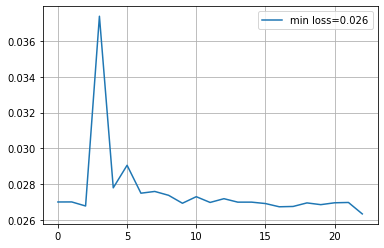

In [34]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()